In [1]:
import os
cwd = os.getcwd().replace('/reinforcement_learning', '')
os.chdir(cwd)

In [2]:
from dataset import Dataset
import gym
import gym_anytrading
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import quantstats as qs


In [3]:
data_binance = Dataset().get_data(days=90, ticker='BTCUSDT', ts='5m')

In [4]:
df = data_binance.copy()[['open', 'high', 'low', 'close', 'volume']]
df = df.reset_index()
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df.set_index('Date')

In [5]:
window_size = 500
start_index = window_size
end_index = len(df)


def create_env(df, start_index, end_index, window_size):
    env = gym.make('forex-v0', df=df,  frame_bound=(start_index,
                   end_index), window_size=window_size)
    env.trade_fee = 0
    return env


def env_maker():
    return create_env(df, start_index, end_index, window_size)

In [7]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


In [8]:
# Create log dir
log_dir = "reinforcement_learning/tmp/"
os.makedirs(log_dir, exist_ok=True)

Num timesteps: 30000
Best mean reward: -inf - Last mean reward per episode: -169880600.00
Saving new best model to reinforcement_learning/tmp/best_model.zip
Num timesteps: 40000
Best mean reward: -169880600.00 - Last mean reward per episode: -169880600.00
Num timesteps: 50000
Best mean reward: -169880600.00 - Last mean reward per episode: -169880600.00
Num timesteps: 60000
Best mean reward: -169880600.00 - Last mean reward per episode: -154717400.00
Saving new best model to reinforcement_learning/tmp/best_model.zip
Num timesteps: 70000
Best mean reward: -154717400.00 - Last mean reward per episode: -154717400.00
Num timesteps: 80000
Best mean reward: -154717400.00 - Last mean reward per episode: -138903600.00
Saving new best model to reinforcement_learning/tmp/best_model.zip
Num timesteps: 90000
Best mean reward: -138903600.00 - Last mean reward per episode: -138903600.00
Num timesteps: 100000
Best mean reward: -138903600.00 - Last mean reward per episode: -138903600.00
Num timesteps: 

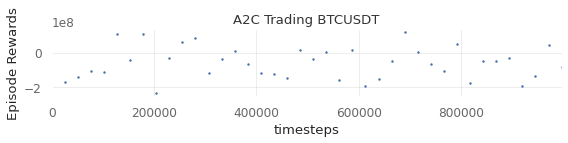

In [49]:
# Create and wrap the environment
env = create_env(df, start_index, end_index, window_size)
env = Monitor(env, log_dir)

model = PPO('MlpPolicy', env, verbose=0)

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)

# Train the agent
timesteps = 1e6
model.learn(total_timesteps=int(timesteps), callback=callback)
plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS,
             "A2C Trading BTCUSDT")
plt.show()


In [50]:
model = PPO.load("reinforcement_learning/tmp/best_model.zip")

In [51]:
env = create_env(df, start_index, end_index, window_size)

info {'total_reward': 190360599.99999705, 'total_profit': 1.5558989407084582, 'position': 0}


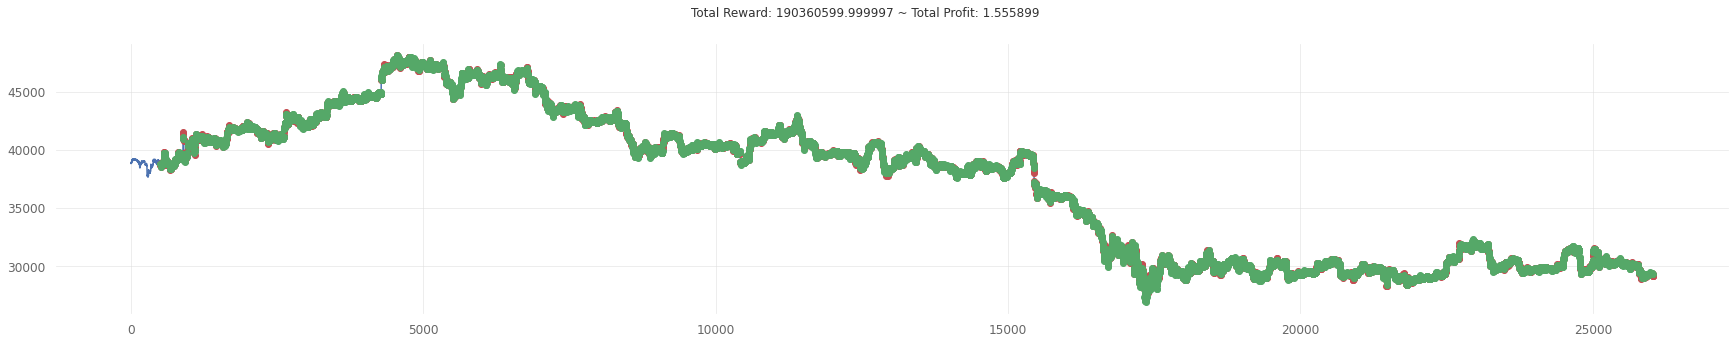

In [52]:
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(30, 5))
# plt.cla()
env.render_all()
plt.show()


                           Strategy
-------------------------  ----------
Start Period               2022-03-14
End Period                 2022-06-11
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          55.59%
CAGR﹪                     525.59%

Sharpe                     0.2
Prob. Sharpe Ratio         97.94%
Smart Sharpe               0.2
Sortino                    0.3
Smart Sortino              0.3
Sortino/√2                 0.21
Smart Sortino/√2           0.21
Omega                      1.09

Max Drawdown               -11.12%
Longest DD Days            27
Volatility (ann.)          2.26%
Calmar                     47.25
Skew                       0.98
Kurtosis                   99.49

Expected Daily %           0.0%
Expected Monthly %         11.69%
Expected Yearly %          55.59%
Kelly Criterion            4.19%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.23%
Expected Shortfall (cVaR)  -0.23%

Max Consecutive Wins       1


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-05-09,2022-05-11,2022-05-12,2,-11.122454,-10.842289
2,2022-03-15,2022-03-31,2022-04-11,27,-10.637935,-10.094257
3,2022-05-14,2022-05-19,2022-05-26,11,-8.464323,-8.054972
4,2022-05-27,2022-05-31,2022-06-01,5,-7.320967,-7.116387
5,2022-05-13,2022-05-13,2022-05-14,1,-6.945416,-6.528845


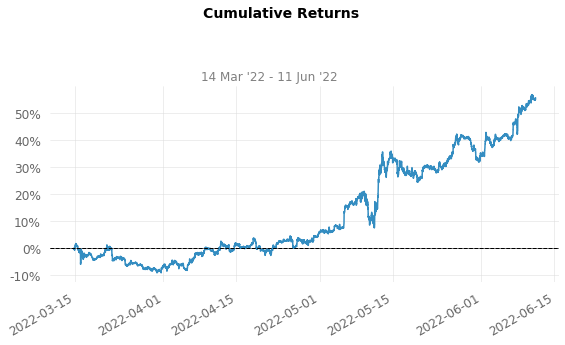

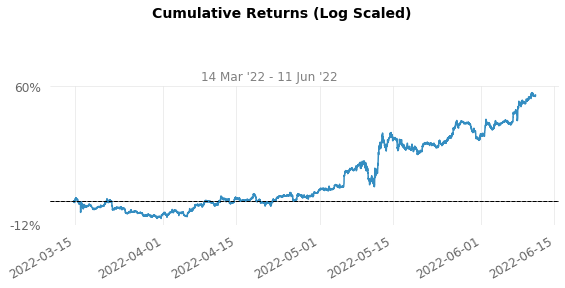

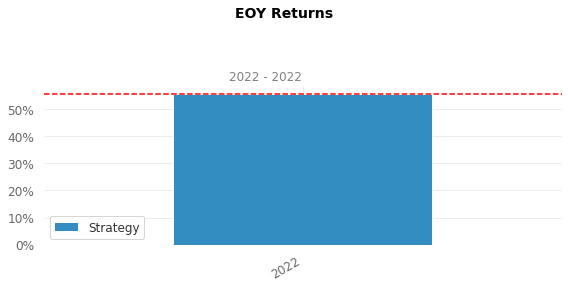

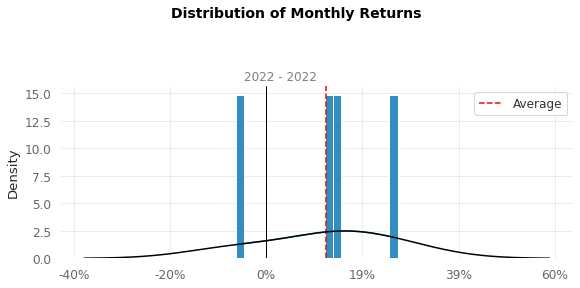

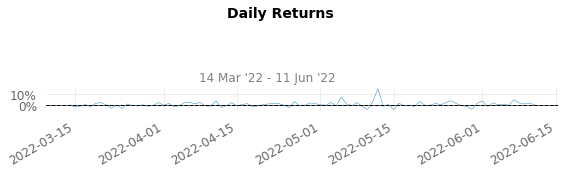

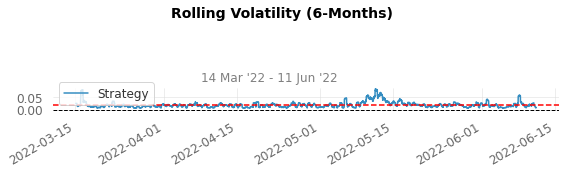

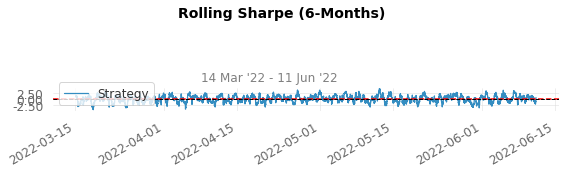

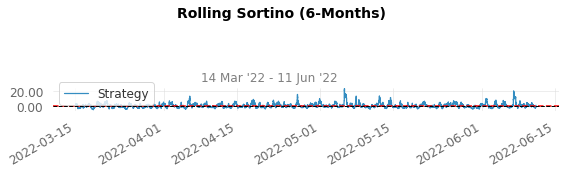

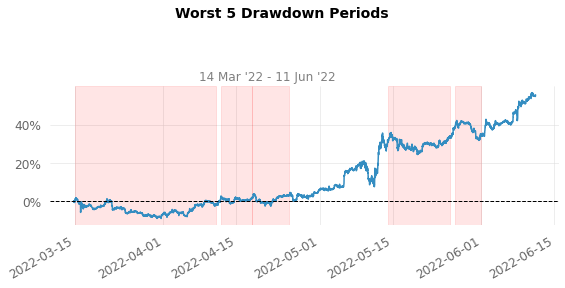

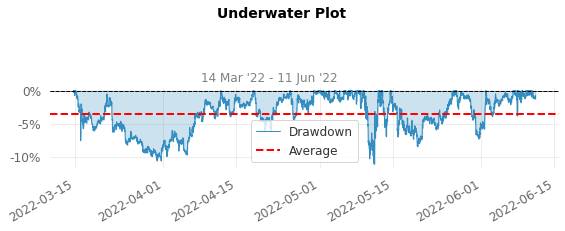

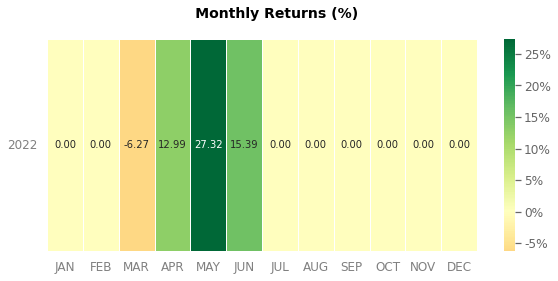

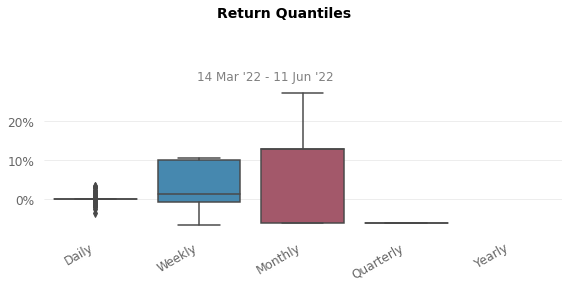

In [53]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
# qs.reports.html(returns, output='reinforcement_learning/a2c_quantstats.html')